## Loading the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

In [2]:
PATH = ''

In [3]:
train_images = f'{PATH}train-images-idx3-ubyte'
train_labels = f'{PATH}train-labels-idx1-ubyte'
test_images = f'{PATH}t10k-images-idx3-ubyte'
test_labels = f'{PATH}t10k-labels-idx1-ubyte'

In [4]:
def idx_images_to_np(path):
    import numpy as np
    import sys
    f = open(path, 'rb')
    magic_number = int.from_bytes(f.read(4), byteorder='big')
    print("Magic number: ", magic_number)
    n = int.from_bytes(f.read(4), byteorder='big')
    rows = int.from_bytes(f.read(4), byteorder='big')
    cols = int.from_bytes(f.read(4), byteorder='big')
    no_of_pixels = rows * cols
    data = []
    for img in range(n):
        sys.stdout.write('\r')
        sys.stdout.write(f'Loading image {img+1}/{n}')
        sys.stdout.flush()
        data.append([])
        for px in range(no_of_pixels):
            data[-1].append(int.from_bytes(f.read(1), byteorder='big'))
    f.close()
    return((np.array(data), n, rows, cols))

In [5]:
train_x, train_n, height, width = idx_images_to_np(train_images)

Magic number:  2051
Loading image 60000/60000

In [6]:
test_x, test_n, height, width = idx_images_to_np(test_images)

Magic number:  2051
Loading image 10000/10000

In [7]:
def idx_labels_to_np(path):
    import numpy as np
    import sys
    f = open(path, 'rb')
    magic_number = int.from_bytes(f.read(4), byteorder='big')
    print("Magic number: ", magic_number)
    n = int.from_bytes(f.read(4), byteorder='big')
    data = []
    for label in range(n):
        data.append(int.from_bytes(f.read(1), byteorder='big'))
    f.close()
    return((np.array(data), n))

In [8]:
train_y, train_n = idx_labels_to_np(train_labels)

Magic number:  2049


In [9]:
test_y, test_n = idx_labels_to_np(test_labels)

Magic number:  2049


### Randomly shuffling the data

In [10]:
def unision_shuffed(a, b):
    # Returns a shuffled copy of a and b (a and b are shuffled identically, preserving any relationship)
    assert len(a) == len(b)
    random_permutation = np.random.permutation(len(a))
    return(a[random_permutation], b[random_permutation])

In [11]:
train_x, train_y = unision_shuffed(train_x, train_y)

In [12]:
test_x, test_y = unision_shuffed(test_x, test_y)

In [13]:
print('No. of training images: ', train_n)
print('No. of test images: ', test_n)
print('Each image: ', height, 'x', width)

No. of training images:  60000
No. of test images:  10000
Each image:  28 x 28


### Vectorizing the labels

In [14]:
def expand_y(y, no_of_classes):
    y_expanded = np.zeros((len(y), no_of_classes))
    for i in range(len(y)):
        y_expanded[i,y[i]] = 1
    return(y_expanded)

In [15]:
train_y = expand_y(train_y, 10)

In [16]:
test_y = expand_y(test_y, 10)

2


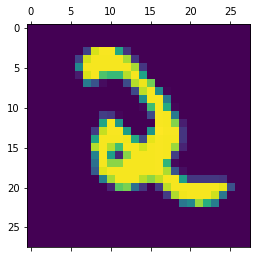

In [17]:
print(test_y[100].argmax())
plt.matshow(np.reshape(test_x[100], (28,28)))

### Visualising the training set

In [18]:
def plot_imgs(imgs, labels, shape, rows, cols, size):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=size)
    for i, img in enumerate(imgs):
        fig.add_subplot(rows, cols, i+1)
        plt.axis('off')
        plt.title(labels[i])
        plt.matshow(np.reshape(img, shape), fignum=False, cmap='gray')

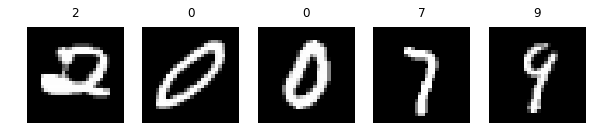

In [19]:
rand_idx = np.random.randint(0, train_n, 5)
rand_imgs = [train_x[r, :] for r in rand_idx]
rnd_labels = [train_y[r].argmax() for r in rand_idx]
plot_imgs(rand_imgs, rnd_labels, (height, width), 2, 5, (10,5))

In [30]:
def avg_graylevel(img):
    return(sum(img)/len(img))

In [133]:
def pixels_horizontal(img):
    px = 364
    g = img[px]
    count = 0
    for i in range(27):
        if g > 0:
            count += 1
        px += 1
        g = img[px]
    return(count)

In [134]:
def pixels_vertical(img):
    px = 13
    g = img[px]
    count = 0
    for i in range(27):
        if g > 0:
            count += 1
        px += 28
        g = img[px]
    return(count)

In [135]:
def plot_featurespace(imgs, labels, features, title='', axis='off'):
    feature_values = []
    for feature in features:
        feature_values.append([feature(img) for img in imgs])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(feature_values[0], feature_values[1], feature_values[2], c=labels)
    plt.title(title)
    plt.axis(axis)

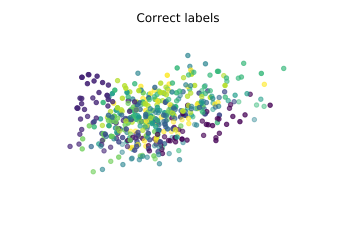

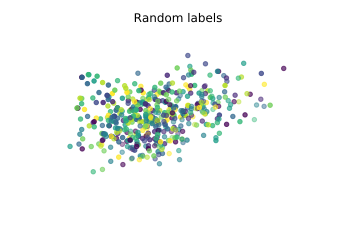

In [147]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D

no_of_images = 500
rand_idx = np.random.randint(0, train_n, no_of_images)
rand_imgs = [train_data[r, :] for r in rand_idx]
rand_labels = [train_y[r] for r in rand_idx]
features = [avg_graylevel, pixels_horizontal, pixels_vertical]

plot_featurespace(rand_imgs, rand_labels, features, title='Correct labels')
np.random.shuffle(rand_labels)
plot_featurespace(rand_imgs, rand_labels, features, title='Random labels')

The naive explorations above show how complex the problem really is. With simple generic features like avg. graylevel, the characters are simple not distinguishible.

## Training the model

In [20]:
class network:
    
    def __init__(self, arch, act, dact):
        import numpy as np
        # Initializes with random weights
        self.arch = arch
        self.act = act
        self.dact = dact
        # Biases are represented by weights from a hiddent constant-input neuron
        # weights is the list of transposed weight arrays (including bias)
        self.weights = [np.random.randn(self.arch[i+1], self.arch[i]+1)
                        for i in range(len(self.arch)-1)]
    
    def forward(self, inp):
        # Returns activations of all the layers
        activation = inp.copy()
        activations = [inp.copy()]
        for layer in range(len(self.arch)-1):
            # Concatenation of 1 is for bias (virtual) neuron
            activation = np.concatenate((activation, [[1]]))
            activation = self.act(self.weights[layer].dot(activation))
            activations.append(activation)
        return(activations)
    
    def backward(self, activations, expected_output):
        # Backpropogates error and returns gradients
        grads = []
        error = expected_output - activations[-1]
        for layer in reversed(range(1,len(self.arch))):
            act_next = activations[layer]
            act_prev = np.concatenate((activations[layer-1], [[1]])).transpose()
            grad = - error * (act_next*(1-act_next)).dot(act_prev)
            grads.append(grad.transpose())
            error = self.weights[layer-1][:,:-1].transpose().dot(error)
        return(grads)
    
    def update(self, grads, learn_rate):
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] - learn_rate * grads[i].transpose()
            
    def cost(self, data_x, data_y):
        total_cost = 0
        for i in range(len(data_x)):
            inp = np.resize(data_x[i,:], (len(data_x[i,:]),1))
            out = self.predict(inp)
            err = out - np.resize(data_y[i,:], (len(data_y[i,:]),1))
            cost = sum(err**2) / len(err)
            total_cost += cost
        return((total_cost/len(data_x))[0])
        
    def train(self, data_x, data_y, cost_data_n, batch_size, no_of_epochs, learn_rate, test_x=None, test_y=None):
        # Trains the NN
        costs = []
        no_of_batches = len(data_x) // batch_size
        print('epoch\tbatch\ttrn_cost\t\ttest_cost\t\taccuracy')
        for epoch in range(no_of_epochs):
            data_x, data_y = unision_shuffed(data_x, data_y)
            data_cost_x = data_x[-cost_data_n:,:]
            data_cost_y = data_y[-cost_data_n:,:]
            batch_costs = np.zeros(no_of_batches+1)
            for batch in range(no_of_batches):
                batch_costs[batch] = self.cost(data_cost_x, data_cost_y)
                total_grad = [0 for i in range(batch_size)]
                for i in range(batch_size):
                    inp = data_x[batch*batch_size+i, :]
                    inp = np.resize(inp, (len(inp),1))
                    out = data_y[batch*batch_size+i, :]
                    out = np.resize(out, (len(out),1))
                    activations = self.forward(inp)
                    grad = self.backward(activations, out)
                    total_grad = [np.add(tg,g) for tg, g in zip(total_grad, grad)]
                avg_grad = [grad/batch_size for grad in reversed(total_grad)]
                self.update(avg_grad, learn_rate)
                sys.stdout.write('\r'+f'{epoch+1}/{no_of_epochs}\t{batch+1}/{no_of_batches}\t{batch_costs[batch]}')
                sys.stdout.flush()
            batch_costs[-1] = self.cost(data_cost_x, data_cost_y)
            costs.append(batch_costs)
            if test_x is not None and test_y is not None: 
                print('\t', self.cost(test_x, test_y), '\t', self.test(test_x, test_y))
        return(costs)
    
    def predict(self, inp):
        # Just like forward, but more effecient; Only returns output
        activation = inp.copy()
        for layer in range(len(self.arch)-1):
            activation = np.concatenate((activation, [[1]]))
            activation = self.act(self.weights[layer].dot(activation))
        return(activation)
    
    def test(self, test_x, test_y):
        correct = 0
        for x, y in zip(test_x, test_y):
            p = self.predict(np.resize(x, (len(x),1)))
            if p.argmax() == y.argmax():
                correct += 1
        return(correct/len(test_x))

In [21]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))
def sigmoid_derivative(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [22]:
nn = network([784, 392, 98, 10], sigmoid, sigmoid_derivative)

In [23]:
nn.test(test_x, test_y)

0.1051

In [24]:
cost_data_n = 50
costs = nn.train(train_x, train_y, cost_data_n, 600, 8, 0.1, test_x=test_x, test_y=test_y)

epoch	batch	trn_cost		test_cost		accuracy
1/8	100/100	0.06908371817757109	 0.06808457819298028 	 0.5352
2/8	100/100	0.048972356985057856	 0.051838490070676334 	 0.6665
3/8	100/100	0.05335100276434246	 0.044415475038273346 	 0.7305
4/8	100/100	0.05393525988416579	 0.04236454145526031 	 0.7414
5/8	100/100	0.04108409972127251	 0.039127187323012534 	 0.7652
6/8	100/100	0.03210403027040513	 0.03709948496287401 	 0.7792
7/8	100/100	0.039974803220568324	 0.03324308593234778 	 0.808
8/8	100/100	0.037401927711400655	 0.0319884523446831 	 0.818


In [25]:
costs = nn.train(train_x, train_y, cost_data_n, 600, 1, 0.01, test_x=test_x, test_y=test_y)

epoch	batch	trn_cost		test_cost		accuracy
1/1	100/100	0.03448340753335236	 0.03095936023512946 	 0.825


In [26]:
costs = nn.train(train_x, train_y, cost_data_n, 600, 1, 0.01, test_x=test_x, test_y=test_y)

epoch	batch	trn_cost		test_cost		accuracy
1/1	100/100	0.03684869542096251	 0.030091617281315736 	 0.8249


In [27]:
import copy
backup_weights = copy.deepcopy(nn.weights)

In [31]:
nn.weights = copy.deepcopy(backup_weights)

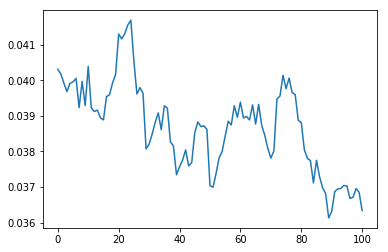

In [30]:
plt.plot(range(len(costs[0])), costs[0])

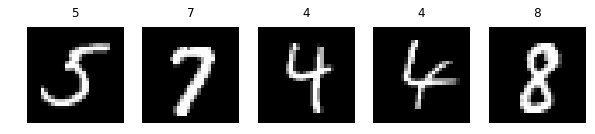

In [33]:
rand_idx = np.random.randint(0, train_n, 5)
rand_imgs = train_x[rand_idx,:]
rnd_labels = [nn.predict(np.resize(train_x[r,:],(len(train_x[r,:]),1))).argmax() for r in rand_idx]
plot_imgs(rand_imgs, rnd_labels, (height, width), 2, 5, (10,5))